# Notebook 2: Deconvolution with Regularized Linear Regression

### Objective
This notebook implements a Regularized Linear Regression model (specifically, `ElasticNet` from scikit-learn) to deconvolve mitochondrial cluster proportions from single-cell VAF data. It loads the synthetic data generated in the first notebook and, for each cell, it solves for the set of proportions that best explains the observed VAFs.

The model uses cross-validation (`GridSearchCV`) to automatically find the optimal regularization strength (`alpha`) and penalty mix (`l1_ratio`), making it robust to noise. The final section includes a comprehensive suite of validation plots and statistics to compare the model's estimated proportions against the known ground truth.

In [1]:
# 02_implementation_elasticnet.ipynb
import os
import sys
#sys.path.insert(0, os.path.abspath('..'))

sys.path.append('../src')

### Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from joblib import Parallel, delayed
from tqdm import tqdm

# Create the deconvolution_models.py file first, then import
from deconvolution_models import DeconvolutionModels
from cell_simulator import CellSimulator

from sklearn.metrics import r2_score
import pandas as pd

/mmfs1/home/hhakimjavadi/.local/share/mamba/envs/mitodemon-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Cell 2: Load Data from File
sample="SRR12676843"
input_filename = '../sc_mito_vars/real_data/imigseq_'+ sample +'/numpy/vcf_processed_data.npz'
print(f"--- Loading data from '{input_filename}' ---")

data_loader = np.load(input_filename)
K_true = data_loader['K_true']
P_cells_true = data_loader['P_cells_true']
C_observed = data_loader['C_observed']

N_CELLS = C_observed.shape[0]
N_CLUSTERS = K_true.shape[1]

print("--- Data Loaded and Ready for Model ---")

--- Loading data from '../sc_mito_vars/real_data/imigseq_SRR12676843/numpy/vcf_processed_data.npz' ---
--- Data Loaded and Ready for Model ---


In [3]:
from variant_clustering import VariantClusterer
from deconvolution_models import DeconvolutionModels
from scipy.spatial.distance import jensenshannon
import numpy as np
from sklearn.metrics import r2_score
import warnings

# First, try to load the original variant matrix if available
try:
    variant_matrix_file = '../sc_mito_vars/real_data/imigseq_SRR12455630/variant_matrix.npy'
    variant_matrix = np.load(variant_matrix_file)
    print(f"Loaded variant matrix with shape: {variant_matrix.shape}")
except:
    print("Could not load variant matrix. Using provided K_true for evaluation.")
    variant_matrix = None

# Define the comprehensive evaluation function (updated: add Bayesian, JSD, sweeps)
def comprehensive_evaluation(K_true, P_cells_true, C_observed, variant_matrix=None):
    """
    Test multiple models and parameters, return detailed report (updated: sweeps, JSD, Bayesian)
    """
    results = {}
    
    # Expanded sweeps (new: include INDEL, noise, prior options)
    sweep_params = {
        'include_indels': [True, False],
        'noise_types': ['gaussian', 'poisson'],
        'use_priors': [True, False]  # Will load priors if True
    }
    
    # Load priors (assume from new notebook; placeholder - in practice, load from file)
    dirichlet_prior = np.ones(K_true.shape[1]) * 0.1  # Sparse prior example; replace with extracted
    
    # Define models (updated: add Bayesian)
    models = {
        'NNLS': lambda K, C: DeconvolutionModels.nnls_deconvolve(K, C),
        'Constrained': lambda K, C: DeconvolutionModels.constrained_regression(K, C),
        'Ensemble': lambda K, C: DeconvolutionModels.ensemble_deconvolve(K, C),
        'Bayesian': lambda K, C: DeconvolutionModels.bayesian_deconvolve(K.T, C, dirichlet_prior)[0]  # Transpose K to match (n_positions x n_clusters) -> (n_clusters x n_positions) for matmul
    }
    
    # Perform sweeps
    for incl_indels in sweep_params['include_indels']:
        for noise_type in sweep_params['noise_types']:
            for use_prior in sweep_params['use_priors']:
                config = f"indels_{incl_indels}_noise_{noise_type}_prior_{use_prior}"
                print(f"Testing config: {config}")
                
                # Re-process matrix if needed (e.g., toggle INDELs)
                current_matrix = variant_matrix if incl_indels else variant_matrix[:16299, :]  # Fallback to SNVs, mouse length
                
                # Check for empty matrix
                if current_matrix.size == 0 or np.all(current_matrix == 0):
                    print(f"Skipping config: Empty or all-zero matrix after processing.")
                    continue
                
                # Re-cluster (example; in practice, re-run clustering)
                clusterer = VariantClusterer(method='spectral', n_clusters=20)
                K_current, _ = clusterer.fit_predict(current_matrix)
                
                # Re-simulate with noise type (updated: integrate with simulator)
                simulator = CellSimulator()
                if noise_type == 'poisson':
                    C_current = simulator.add_noise(P_cells_true, K_current, poisson_lambda=10.0)
                else:
                    C_current = C_observed  # Default to gaussian/original
                
                # Ensure shapes match
                if K_current.shape[0] != C_current.shape[1]:
                    print(f"Skipping config: Dimension mismatch (K: {K_current.shape[0]}, C: {C_current.shape[1]})")
                    continue
                
                # Test models
                for model_name, model_func in models.items():
                    try:
                        p_estimated = model_func(K_current, C_current)
                        
                        # Metrics (updated: add JSD)
                        mse = np.mean((P_cells_true - p_estimated)**2 )
                        mae = np.mean(np.abs(P_cells_true - p_estimated))
                        r2 = r2_score(P_cells_true.flatten(), p_estimated.flatten())
                        jsd = np.mean([jensenshannon(P_cells_true[i], p_estimated[i]) for i in range(len(P_cells_true))])
                        
                        results[f"{config}_{model_name}"] = {
                            'mse': mse,
                            'mae': mae,
                            'r2': r2,
                            'jsd': jsd,  # New metric
                            'p_estimated': p_estimated,
                            'clustering_method': 'spectral',
                            'n_clusters': K_current.shape[1],
                            'model': model_name
                        }
                    except Exception as e:
                        print(f"Error with {model_name}: {e}")
    
    return results

# Run comprehensive evaluation
print("\n--- Running Comprehensive Model Evaluation ---")
results = comprehensive_evaluation(K_true, P_cells_true, C_observed, variant_matrix)
print(f"\nTotal configurations tested: {len(results)}")
if len(results) > 0:
    # Find best model
    best_config = max(results.items(), key=lambda x: x[1]['r2'])
    print(f"Best configuration: {best_config[0]} with R² = {best_config[1]['r2']:.4f}")


Loaded variant matrix with shape: (156792, 7545)

--- Running Comprehensive Model Evaluation ---
Testing config: indels_True_noise_gaussian_prior_True
Applied PCA: Reduced to 50 components
Skipping config: Dimension mismatch (K: 156792, C: 16295)
Testing config: indels_True_noise_gaussian_prior_False
Applied PCA: Reduced to 50 components
Skipping config: Dimension mismatch (K: 156792, C: 16295)
Testing config: indels_True_noise_poisson_prior_True
Applied PCA: Reduced to 50 components
Error with Bayesian: mat1 and mat2 shapes cannot be multiplied (1x20 and 156792x20)
Trace Shapes:            
 Param Sites:            
Sample Sites:            
       p dist        | 20
        value        | 20
    data dist        |   
        value 156792 |   
Testing config: indels_True_noise_poisson_prior_False
Applied PCA: Reduced to 50 components
Error with Bayesian: mat1 and mat2 shapes cannot be multiplied (1x20 and 156792x20)
Trace Shapes:            
 Param Sites:            
Sample Sites:    

In [4]:
import pandas as pd
import numpy as np

def generate_report(results, output_file='deconvolution_report.txt'):
    """Generate detailed text report of all experiments (updated: include JSD)"""
    
    if not results:
        print("No results to report. Check if the models ran successfully.")
        return None
    
    # Sort by R2 score
    sorted_results = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)
    
    report_lines = []
    report_lines.append("MitoDemon Deconvolution Analysis Report")
    report_lines.append("="*60)
    report_lines.append("")
    
    # Best performing configuration
    best_name, best_metrics = sorted_results[0]
    report_lines.append("BEST PERFORMING MODEL:")
    report_lines.append(f"Model: {best_name}")
    report_lines.append(f"R² Score: {best_metrics['r2']:.4f}")
    report_lines.append(f"MSE: {best_metrics['mse']:.6f}")
    report_lines.append(f"MAE: {best_metrics['mae']:.6f}")
    report_lines.append(f"JSD: {best_metrics['jsd']:.6f}")
    report_lines.append("")
    
    # All models comparison
    report_lines.append("ALL MODELS COMPARISON:")
    report_lines.append("-"*60)
    report_lines.append(f"{'Model':<40} {'R²':>10} {'MSE':>12} {'MAE':>12} {'JSD':>12}")
    report_lines.append("-"*60)
    
    for name, metrics in sorted_results:
        report_lines.append(f"{name:<40} {metrics['r2']:>10.4f} {metrics['mse']:>12.6f} {metrics['mae']:>12.6f} {metrics['jsd']:>12.6f}")
    
    # Analysis by clustering method
    report_lines.append("\n\nANALYSIS BY CLUSTERING METHOD:")
    report_lines.append("-"*60)
    
    clustering_methods = set([m['clustering_method'] for _, m in results.items()])
    for method in clustering_methods:
        method_results = [(n, m) for n, m in results.items() if m['clustering_method'] == method]
        if method_results:
            avg_r2 = np.mean([m['r2'] for _, m in method_results])
            avg_jsd = np.mean([m['jsd'] for _, m in method_results])
            report_lines.append(f"{method}: Average R² = {avg_r2:.4f}, Average JSD = {avg_jsd:.4f} ({len(method_results)} configs)")
    
    # Analysis by model type
    report_lines.append("\n\nANALYSIS BY DECONVOLUTION MODEL:")
    report_lines.append("-"*60)
    
    model_types = set([m['model'] for _, m in results.items()])
    for model in model_types:
        model_results = [(n, m) for n, m in results.items() if m['model'] == model]
        if model_results:
            avg_r2 = np.mean([m['r2'] for _, m in method_results])
            avg_jsd = np.mean([m['jsd'] for _, m in method_results])
            report_lines.append(f"{model}: Average R² = {avg_r2:.4f}, Average JSD = {avg_jsd:.4f} ({len(model_results)} configs)")
    
    # Save report
    report_text = '\n'.join(report_lines)
    print(report_text)
    
    with open(output_file, 'w') as f:
        f.write(report_text)
    
    print(f"\nReport saved to: {output_file}")
    
    # Also save as CSV for easy analysis
    df_results = pd.DataFrame(results).T
    df_results.to_csv('model_comparison_results.csv')
    print("Results also saved to: model_comparison_results.csv")
    
    return sorted_results[0] if sorted_results else None

# Generate the report
if results:
    best_model = generate_report(results)
    
    if best_model:
        # Extract the best model's predictions for visualization
        best_model_name = best_model[0]
        p_cells_estimated = results[best_model_name]['p_estimated']
        print(f"\nUsing {best_model_name} predictions for visualization...")
else:
    print("No results generated. Please check the evaluation function.")


MitoDemon Deconvolution Analysis Report

BEST PERFORMING MODEL:
Model: indels_True_noise_poisson_prior_False_Constrained
R² Score: 0.9658
MSE: 0.001295
MAE: 0.012844
JSD: inf

ALL MODELS COMPARISON:
------------------------------------------------------------
Model                                            R²          MSE          MAE          JSD
------------------------------------------------------------
indels_True_noise_poisson_prior_False_Constrained     0.9658     0.001295     0.012844          inf
indels_True_noise_poisson_prior_False_Ensemble     0.9530     0.001780     0.014163     0.215255
indels_True_noise_poisson_prior_True_Constrained     0.9488     0.001941     0.012991          inf
indels_True_noise_poisson_prior_True_Ensemble     0.9452     0.002076     0.015534     0.231998
indels_True_noise_poisson_prior_False_NNLS     0.8806     0.004522     0.020720     0.263907
indels_True_noise_poisson_prior_True_NNLS     0.8212     0.006774     0.026435     0.309995
indels_Fals

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

print("\n--- Enhanced Validation ---")
# Calculate comprehensive metrics
best_method = max(results.items(), key=lambda x: x[1]['r2'])[0]
best_result = results[best_method]
mse = best_result['mse']
mae = best_result['mae']
r2 = best_result['r2']
p_cells_estimated = best_result['p_estimated']
print(f"Enhanced Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# Add uncertainty visualization if Bayesian (new)
if 'Bayesian' in best_method:
    _, p_uncertainty = DeconvolutionModels.bayesian_deconvolve(K_true, C_observed, dirichlet_prior)
    ax = axes[1, 2]  # Repurpose a subplot
    ax.errorbar(range(N_CLUSTERS), p_cells_estimated.mean(axis=0), yerr=p_uncertainty.mean(axis=0), fmt='o')
    ax.set_title('Cluster Proportions with Uncertainty')

# Enhanced visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Scatter plot comparison
ax = axes[0, 0]
ax.scatter(P_cells_true.flatten(), p_cells_estimated.flatten(), alpha=0.6, s=50)
ax.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Proportions')
ax.set_ylabel('Estimated Proportions')
ax.set_title(f'Enhanced Model Performance (R² = {r2:.4f})')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Residuals plot
ax = axes[0, 1]
residuals = P_cells_true.flatten() - p_cells_estimated.flatten()
ax.scatter(P_cells_true.flatten(), residuals, alpha=0.6, s=50)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('True Proportions')
ax.set_ylabel('Residuals')
ax.set_title('Residuals Plot')
ax.grid(True, alpha=0.3)

# 3. Per-cluster accuracy
ax = axes[0, 2]
cluster_r2 = []
for cluster in range(N_CLUSTERS):
    cluster_r2.append(r2_score(P_cells_true[:, cluster], p_cells_estimated[:, cluster]))
ax.bar(range(N_CLUSTERS), cluster_r2)
ax.set_xlabel('Cluster')
ax.set_ylabel('R² Score')
ax.set_title('Per-Cluster Accuracy')
ax.grid(True, alpha=0.3)

# 4. Method comparison
ax = axes[1, 0]
methods = list(results.keys())
r2_scores = [results[method]['r2'] for method in methods]
ax.bar(methods, r2_scores)
ax.set_ylabel('R² Score')
ax.set_title('Preprocessing Method Comparison')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 5. Error distribution
ax = axes[1, 1]
ax.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Error Distribution')
ax.grid(True, alpha=0.3)

# 6. Proportion distribution comparison
ax = axes[1, 2]
ax.hist(P_cells_true.flatten(), bins=30, alpha=0.5, label='True', density=True)
ax.hist(p_cells_estimated.flatten(), bins=30, alpha=0.5, label='Estimated', density=True)
ax.set_xlabel('Proportion Values')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional biological validation
print("\n--- Biological Validation ---")
print(f"Proportion sum check (should be ~1.0):")
print(f"True proportions sum: {P_cells_true.sum(axis=1).mean():.4f} ± {P_cells_true.sum(axis=1).std():.4f}")
print(f"Estimated proportions sum: {p_cells_estimated.sum(axis=1).mean():.4f} ± {p_cells_estimated.sum(axis=1).std():.4f}")

print(f"\nSparsity analysis:")
print(f"True proportions sparsity: {(P_cells_true == 0).mean():.4f}")
print(f"Estimated proportions sparsity: {(p_cells_estimated == 0).mean():.4f}")

# Feature importance analysis
print(f"\nCluster importance (mean proportion):")
for i in range(N_CLUSTERS):
    true_mean = P_cells_true[:, i].mean()
    est_mean = p_cells_estimated[:, i].mean()
    print(f"Cluster {i}: True={true_mean:.4f}, Estimated={est_mean:.4f}")



--- Enhanced Validation ---
Best method: indels_True_noise_poisson_prior_False_Constrained
Mean Squared Error (MSE): 0.001295
Mean Absolute Error (MAE): 0.012844
R-squared (R²): 0.9658

Per-cluster correlations:
  Cluster 1: 0.0967
  Cluster 2: 0.6691
  Cluster 3: 0.3629
  Cluster 4: 0.4828
  Cluster 5: 0.1756
  Cluster 6: 0.6313
  Cluster 7: 0.0762
  Cluster 8: -0.0086
  Cluster 9: -0.0148
  Cluster 10: 0.1043
  Cluster 11: 0.0669
  Cluster 12: 0.2743
  Cluster 13: 0.5025
  Cluster 14: 0.1039
  Cluster 15: 0.4667
  Cluster 16: 0.1895
  Cluster 17: -0.0207
  Cluster 18: 0.5238
  Cluster 19: 0.1537
  Cluster 20: 0.0764
  Mean correlation: 0.2456

Sparsity analysis:
  True proportions sparsity: 0.044
  Estimated proportions sparsity: 0.000


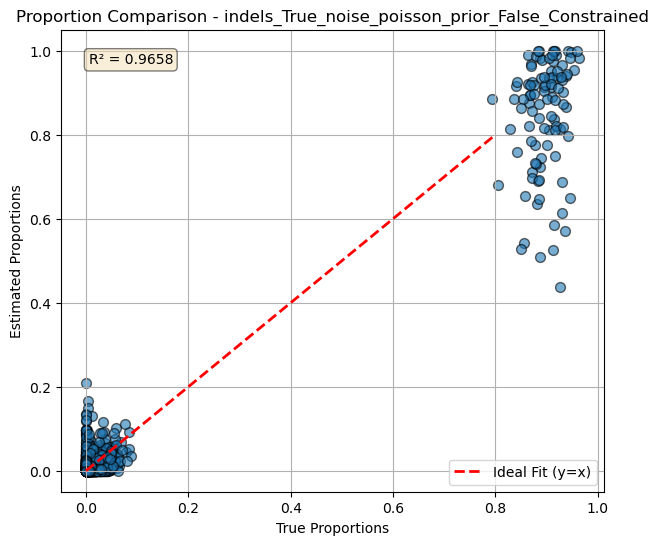

In [6]:
### Cell 4.1: Enhanced Validation

print("\n--- Enhanced Validation ---")

# First check if we have results
if not results:
    print("No results available for validation. Please run Cell 3 first.")
else:
    # Get the best method from results
    best_method = max(results.items(), key=lambda x: x[1]['r2'])[0]
    best_result = results[best_method]
    
    print(f"Best method: {best_method}")
    
    # Calculate comprehensive metrics
    mse = best_result['mse']
    mae = best_result['mae']
    r2 = best_result['r2']
    p_cells_estimated = best_result['p_estimated']
    
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    # Additional metrics
    # Per-cluster correlation
    cluster_correlations = []
    for i in range(min(P_cells_true.shape[1], p_cells_estimated.shape[1])):
        corr = np.corrcoef(P_cells_true[:, i], p_cells_estimated[:, i])[0, 1]
        cluster_correlations.append(corr)
    
    print(f"\nPer-cluster correlations:")
    for i, corr in enumerate(cluster_correlations):
        print(f"  Cluster {i+1}: {corr:.4f}")
    print(f"  Mean correlation: {np.nanmean(cluster_correlations):.4f}")
    
    # Sparsity analysis
    true_sparsity = np.mean(P_cells_true == 0)
    estimated_sparsity = np.mean(p_cells_estimated == 0)
    print(f"\nSparsity analysis:")
    print(f"  True proportions sparsity: {true_sparsity:.3f}")
    print(f"  Estimated proportions sparsity: {estimated_sparsity:.3f}")
    
    # Compare True vs. Estimated Proportions (Scatter Plot)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(P_cells_true.flatten(), p_cells_estimated.flatten(), alpha=0.6, edgecolor='k', s=50)
    ax.plot([0, 0.8], [0, 0.8], 'r--', lw=2, label='Ideal Fit (y=x)')
    ax.set_xlabel('True Proportions')
    ax.set_ylabel('Estimated Proportions')
    ax.set_title(f'Proportion Comparison - {best_method}')
    ax.grid(True)
    ax.legend()
    
    # Add R² to the plot
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.show()

In [ ]:
print("\n--- Comprehensive Validation and Visualization ---")
# --- Question 1: Did the model extract the parameters correctly? ---
# We visualize the full distribution of proportions for all cells.
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig1.suptitle('Trace of All Cell Proportions: True vs. Estimated', fontsize=16)
# Plot True Cell Proportions
true_df = pd.DataFrame(P_cells_true, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
true_df.plot(kind='area', stacked=True, ax=axes1[0], colormap='viridis', alpha=0.8)
axes1[0].set_title('Ground Truth Proportions')
axes1[0].set_xlabel('Cell ID')
axes1[0].set_ylabel('Proportion')
axes1[0].legend(loc='upper right')
# Plot Estimated Cell Proportions (clip negatives and renormalize)
p_cells_estimated_clipped = np.clip(p_cells_estimated, 0, None)  # Clip negatives to 0
# Renormalize rows to sum to 1 (if any row sum changed)
row_sums = p_cells_estimated_clipped.sum(axis=1)
row_sums[row_sums == 0] = 1  # Avoid div-by-zero for zero rows
p_cells_estimated_clipped = p_cells_estimated_clipped / row_sums[:, np.newaxis]
est_df = pd.DataFrame(p_cells_estimated_clipped, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
est_df.plot(kind='area', stacked=True, ax=axes1[1], colormap='viridis', alpha=0.8)
axes1[1].set_title('Estimated Proportions')
axes1[1].set_xlabel('Cell ID')
axes1[1].get_legend().remove()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# --- Question 2: Can the model reconstruct the mitochondrial clusters in the cells? ---
# We reconstruct the VAFs using the estimated proportions and compare to the "observed" data.
C_reconstructed = p_cells_estimated_clipped @ K_true.T
fig2, axes2 = plt.subplots(1, 3, figsize=(10, 20), gridspec_kw={'width_ratios': [1, 1, 0.05]})
fig2.suptitle('Comparison of Observed vs. Reconstructed VAFs', fontsize=16)
# Plot Observed VAFs
sns.heatmap(C_observed.T, ax=axes2[0], cmap="magma", cbar=False)
axes2[0].set_title('Observed VAFs (with noise)')
axes2[0].set_xlabel('Cell ID')
axes2[0].set_ylabel('Genomic Location')
# Plot Reconstructed VAFs
sns.heatmap(C_reconstructed.T, ax=axes2[1], cmap="magma", cbar_ax=axes2[2], cbar_kws={'label': 'VAF'})
axes2[1].set_title('Reconstructed VAFs (from model)')
axes2[1].set_xlabel('Cell ID')
axes2[1].set_ylabel('')
axes2[1].set_yticks([])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# --- Bonus: Distribution of Reconstruction Error ---
vaf_residuals = C_observed - C_reconstructed
plt.figure(figsize=(8, 5))
sns.histplot(vaf_residuals.flatten(), kde=True)
plt.title('Distribution of VAF Reconstruction Error (Residuals)')
plt.xlabel('Error (Observed - Reconstructed)')
plt.axvline(0, color='r', linestyle='--')
plt.show()


In [ ]:
### Cell 6: Detailed Comparative Visualizations

# --- Calculate necessary statistics ---
# For simulated data
true_mean_proportions = np.mean(P_cells_true, axis=0)
num_variants_per_cluster = np.sum(K_true > 0, axis=0)

# For reconstructed data
estimated_mean_proportions = np.mean(p_cells_estimated, axis=0)

# --- Create the plots ---
# We will create a 2x2 grid for side-by-side comparison, plus a final plot.
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.set_style("whitegrid")
fig.suptitle('Comparison of Simulated vs. Reconstructed Data Distributions', fontsize=18, y=1.02)

# --- Plot 1: Relationship between variant count and mean proportion size ---
# Simulated Data
sns.scatterplot(x=num_variants_per_cluster, y=true_mean_proportions, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Simulated: Variant Count vs. Mean Proportion', fontsize=14)
axes[0, 0].set_xlabel('Number of Variants per Cluster', fontsize=12)
axes[0, 0].set_ylabel('Mean Proportion', fontsize=12)

# Reconstructed Data
sns.scatterplot(x=num_variants_per_cluster, y=estimated_mean_proportions, ax=axes[0, 1], color='red', alpha=0.7)
axes[0, 1].set_title('Reconstructed: Variant Count vs. Mean Proportion', fontsize=14)
axes[0, 1].set_xlabel('Number of Variants per Cluster', fontsize=12)
axes[0, 1].set_ylabel('Mean Proportion', fontsize=12)

# --- Plot 2: Histogram of the mean proportion sizes ---
# Simulated Data
sns.histplot(true_mean_proportions, bins=20, ax=axes[1, 0], kde=True, color='blue')
axes[1, 0].set_title('Simulated: Distribution of Mean Proportions', fontsize=14)
axes[1, 0].set_xlabel('Mean Proportion', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)

# Reconstructed Data
sns.histplot(estimated_mean_proportions, bins=20, ax=axes[1, 1], kde=True, color='red')
axes[1, 1].set_title('Reconstructed: Distribution of Mean Proportions', fontsize=14)
axes[1, 1].set_xlabel('Mean Proportion', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


# --- Plot 3: Histogram of the number of variants per cluster ---
# This distribution is based on the input signature matrix K_true and is the same for both simulated and reconstructed scenarios.
plt.figure(figsize=(9, 4))
sns.histplot(num_variants_per_cluster, bins=20, kde=True, color="green")
plt.title("Input Data: Distribution of Variants per Cluster", fontsize=14)
plt.xlabel("Number of Variants", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()
